In [7]:
import os
from dotenv import load_dotenv
from image_helper import ImageHelper
from datetime import datetime

load_dotenv()

base_url = os.environ.get("STORAGE_URL")
assert base_url
im_helper = ImageHelper(base_url)

In [8]:
from plantcv import plantcv as pcv
import matplotlib
import numpy as np
class options:
    def __init__(self):
        self.debug = "plot"
        self.writeimg= False
        self.result = "results.json"
        self.outdir = "." # Store the output to the current directory

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

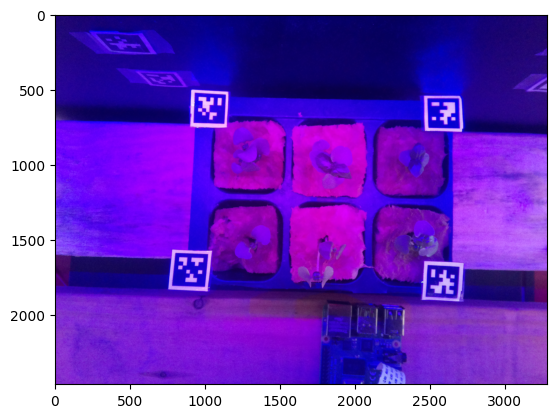

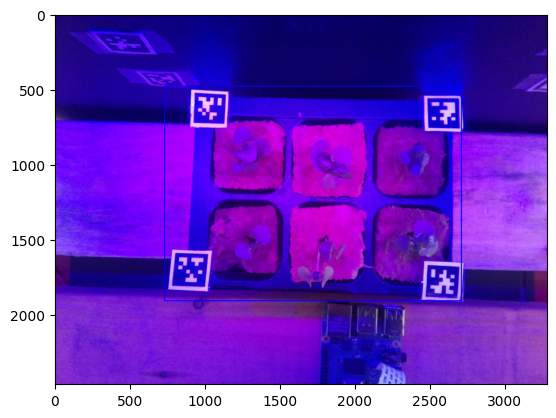

In [9]:
import image_helper
dt_str = '3/12/2022 19:08:18'
dt = im_helper.dt_from_string(dt_str)
assert(im_helper.get(dt, "top"))
img, path, filename = pcv.readimage(im_helper.image.name)
crop_img = pcv.crop(img=img, x=730, y=480, h=1430, w=1980)

In [25]:
def filter(crop_img):
    corrected_img = pcv.white_balance(img=crop_img, mode='hist', roi=[280, 120, 5, 5])
    rotate_img = pcv.transform.rotate(corrected_img, 2, True)
    gray_img = pcv.rgb2gray_lab(rgb_img=rotate_img, channel='b')
    return gray_img

def create_mask(gray_img):
    thresh = pcv.threshold.binary(gray_img=gray_img, threshold=55, max_value=255, object_type='dark')
    rois, roi_hierarchy = pcv.roi.multi(img=gray_img, coord=(550,460), radius=180, 
                                    spacing=(550, 580), nrows=2, ncols=3)
    roi_mask = pcv.roi.roi2mask(img=gray_img, contour=rois[0])
    for r in rois:
        new_mask = pcv.roi.roi2mask(img=gray_img, contour=r)
        roi_mask = np.maximum(roi_mask, new_mask)
    combined_mask = np.minimum(roi_mask, thresh)
    filled_mask = pcv.fill(bin_img=combined_mask, size=200)
    pcv.plot_image(filled_mask)
    return filled_mask, rois, roi_hierarchy

def analyze_shape(rois, roi_hierarchy, crop_img, mask):
    obj, obj_hierarchy = pcv.find_objects(img=img, mask=mask)
    plant_ids = range(0, len(rois))
    img_copy = np.copy(crop_img)
    # Create a for loop to interate through every ROI (plant) in the image
    for i in range(0, len(rois)):
        roi = rois[i]
        hierarchy = roi_hierarchy[i]
        plant_id = plant_ids[i]
        # Subset objects that overlap the ROI
        plant_contours, plant_hierarchy, mask, area = pcv.roi_objects(img=crop_img, 
                                                                    roi_contour=roi, 
                                                                    roi_hierarchy=hierarchy, 
                                                                    object_contour=obj, 
                                                                    obj_hierarchy=obj_hierarchy, 
                                                                    roi_type="partial")

        # If the plant area is zero then no plant was detected for the ROI
        # and no measurements can be done
        if area > 0:
            # Combine contours together for each plant
            plant_obj, plant_mask = pcv.object_composition(img=crop_img, 
                                                        contours=plant_contours, 
                                                        hierarchy=plant_hierarchy)        
            # Analyze the shape of each plant
            img_copy = pcv.analyze_object(img=img_copy, obj=plant_obj, 
                                        mask=plant_mask, label=f"plant{plant_id}")
    pcv.plot_image(img_copy)
    return obj, obj_hierarchy


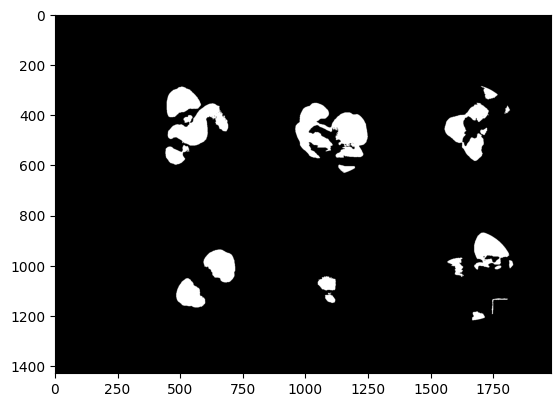

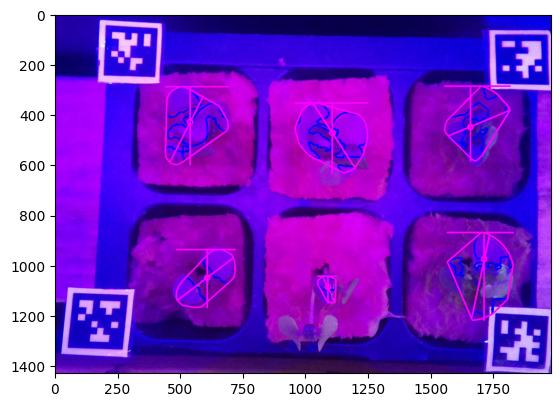

In [31]:
pcv.params.debug = None
gray_img = filter(crop_img)
mask, rois, roi_hierarchy = create_mask(gray_img)
obj, obj_hierarchy = analyze_shape(rois, roi_hierarchy, crop_img, mask)